In [1]:
from flownet import FlowNetPET
from utils import XCAT3DDataset, eval_sum, eval_binned
from analysis_rpb_compare import (load_phantoms, load_breath_motion, sample_images, 
                                  apply_correction, calc_iou, plot_metric_comparison_vert, 
                                  plot_breath_binning, find_voi)
import configparser
import numpy as np
import torch
import os
import h5py

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Using Torch version: %s' % (torch.__version__))

print('Using a %s device' % (device))

# Collect the command line arguments
model_name = 'fnp_1'

# Directories
cur_dir = ''
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')
    
# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)

print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))

input_shape = eval(architecture_config['input_shape'])

# Check for pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')

# Construct Network
print('\nBuilding networks...')
model = FlowNetPET(architecture_config, device)
model.to(device)

# Display model architectures
print('\n\nARCHITECTURE:\n')
print(model.predictor)

# Create data loaders
data_file = os.path.join(data_dir,config['DATA']['data_file'])

val_dataset = XCAT3DDataset(data_file, dataset='val')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

print('\nLoading saved model to continue training...')
# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['model'])

Using Torch version: 1.10.0+cu102
Using a cpu device

Creating model: fnp_1

Configuration:
  DATA
    data_file: xcat_training_set.h5
  TRAINING
    batchsize: 1
    learning_rate: 0.0003
    lr_decay_batch_iters: 8000
    lr_decay: 0.7
    total_batch_iters: 15000
    smooth_weight: 0.0
    res_weights: [1.0, 1.0, 1.0, 1.0]
    l2_weight: 0.0
    inv_weight: 1000.0
  ARCHITECTURE
    input_shape: [108, 152, 152]
    gauss_kernel_len: 15
    gauss_sigma: 0.9
    conv_filts: [16, 32, 64]
    conv_filt_lens: [3, 3, 3]
    conv_strides: [2, 2, 2]
    latent_filters: 256
    interp_mode: bilinear
  Notes
    comment: Original architecture

Building networks...


/home/jupyter-teaghan/.local/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The flow predictions will have sizes:
108 x 152 x 152
54 x 76 x 76
27 x 38 x 38
14 x 19 x 19


ARCHITECTURE:

FlowNetS(
  (conv1): Sequential(
    (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (3): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (3): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (3): ReLU(inplace=True)
  )
  (conv_latent): Sequential(
    (0): Conv3d(64, 256, ke

<All keys matched successfully>

In [11]:
breath_samples_fn = os.path.join('../PETRecML/phantom/xcat', 'VCU_patient_breathing_motion.npz')
breath_data = np.load(breath_samples_fn, allow_pickle=True)
breath_indx=50

list(breath_data.keys())

['patient_ids', 'time_stamp', 'phase', 'amplitude']

In [18]:
pat_ids.shape

(1, 24814)

In [17]:
pat_ids = np.array([breath_data['time_stamp'][breath_indx]])

pat_ids[0]

array([0.00000e+00, 3.30000e-02, 6.70000e-02, ..., 8.29122e+02,
       8.29155e+02, 8.29226e+02])

In [19]:
np.savez('data/clinical_breathing_trace.npz', 
         patient_ids=np.array([breath_data['patient_ids'][breath_indx]]),
        time_stamp=np.array([breath_data['time_stamp'][breath_indx]]),
        phase=np.array([breath_data['phase'][breath_indx]]),
        amplitude=np.array([breath_data['amplitude'][breath_indx]]))

In [2]:
AP_expansions = [0.6,0.8,1.0,1.2,1.4]

pat_num=1
lesn_diameter=25
n_samples=int(12e6)
avg_counts = 9e6
breath_indx=0
rebin=True
tgt_phase=4
amp_bin=True
n_bins=10
tgt_bin=2
h5_fn=os.path.join(data_dir, 'xcat_rpb_compare_test_set.h5')
breath_samples_fn = os.path.join(data_dir, 'clinical_breathing_trace.npz')

tot_counts_gt = []
tot_counts_rb = []
tot_counts_orig = []
tot_counts_corr = []
snr_gt = []
snr_rb = []
snr_orig = []
snr_corr = []
iou_gt = np.ones((len(AP_expansions),))
iou_rb = []
iou_orig = []
iou_corr = []
for AP_expansion in AP_expansions:
    
    # Load the XCAT phantoms
    phantoms, inp_phase_indices, tumour_loc = load_phantoms(h5_fn, pat_num, AP_expansion, lesn_diameter)

    # Load the patient breathing motion
    (breath_time, breath_amp, breath_inp_phase, 
     breath_recon_phase, recon_phase_indices) = load_breath_motion(inp_phase_indices, 
                                                                   breath_samples_fn,
                                                                  breath_indx=breath_indx, rebin=rebin)
    (tgt_img, inp_imgs, gt_img, rb_img, 
     tgt_mask, inp_masks, gt_mask, rb_mask, tgt_phase) = sample_images(phantoms, breath_time, breath_amp, 
                                                                 inp_phase_indices, breath_inp_phase, 
                                                                 recon_phase_indices, breath_recon_phase,
                                                                 tgt_phase, n_samples,
                                                                      amp_bin, n_bins, tgt_bin)

    orig_img, corr_img, orig_mask, corr_mask = apply_correction(model, inp_imgs, tgt_img, inp_masks, tgt_mask,
                                                                avg_counts, device, val_dataset)
    
    thresh = 0.1*np.mean(gt_img[gt_mask.astype(bool)])
    gt_mask[gt_img<thresh] = 0
    orig_mask[orig_img<thresh] = 0
    corr_mask[corr_img<thresh] = 0
    rb_mask[rb_img<thresh] = 0
    print('AP Expansion=%0.1f'%(AP_expansion))

    tot_counts_gt.append(np.sum(gt_img[gt_mask.astype(bool)]))
    tot_counts_rb.append(np.sum(rb_img[gt_mask.astype(bool)]))
    tot_counts_orig.append(np.sum(orig_img[gt_mask.astype(bool)]))
    tot_counts_corr.append(np.sum(corr_img[gt_mask.astype(bool)]))
    print('Total counts enclosed in no motion VOI:')
    print('| No Motion | Retro-Gated | No Correction | Corrected |')
    print('|-----------------------------------------------------|')
    print('| %9i | %11i | %13i | %9i |' % (tot_counts_gt[-1], tot_counts_rb[-1], 
                                           tot_counts_orig[-1], tot_counts_corr[-1]))

    snr_gt.append(np.mean(gt_img[gt_mask.astype(bool)])/np.std(gt_img[gt_mask.astype(bool)]))
    snr_rb.append(np.mean(rb_img[gt_mask.astype(bool)])/np.std(rb_img[gt_mask.astype(bool)]))
    snr_orig.append(np.mean(orig_img[gt_mask.astype(bool)])/np.std(orig_img[gt_mask.astype(bool)]))
    snr_corr.append(np.mean(corr_img[gt_mask.astype(bool)])/np.std(corr_img[gt_mask.astype(bool)]))
    print('Signal to noise ratio of each VOI:')
    print('| No Motion | Retro-Gated | No Correction | Corrected |')
    print('|-----------------------------------------------------|')
    print('| %9.2f | %11.2f | %13.2f | %9.2f |' % (snr_gt[-1], snr_rb[-1], snr_orig[-1], snr_corr[-1]))

    iou_rb.append(calc_iou(gt_mask, rb_mask))
    iou_orig.append(calc_iou(gt_mask, orig_mask))
    iou_corr.append(calc_iou(gt_mask, corr_mask))

    print('Intersection over Union:')
    print('|Retro-Gated | No Correction | Corrected |')
    print('|----------------------------------------|')
    print('|%11.2f | %13.2f | %9.2f |' % (iou_rb[-1], iou_orig[-1], iou_corr[-1]))
    
    if AP_expansion==1.2:
        centre_loc = [int(np.rint(np.mean(loc))) for loc in np.where(gt_mask)]
        zyx_len = np.array([np.max(loc)-np.min(loc) for loc in np.where(gt_mask)]) + np.array([8,4,4])

        # Select VOIs around tumour
        gt_voi = find_voi(gt_img, centre_loc, zyx_len)
        rb_voi = find_voi(rb_img, centre_loc, zyx_len)    
        orig_voi = find_voi(orig_img, centre_loc, zyx_len)
        corr_voi = find_voi(corr_img, centre_loc, zyx_len)
        
        centre_loc = [int(np.rint(np.mean(loc))) for loc in np.where(gt_mask)]
        zyx_len = np.array([np.max(loc)-np.min(loc) for loc in np.where(gt_mask)]) + np.array([8,4,4])
        
        # Save for plotting in MC analysis
        output_file = 'data/rpb_compare_VOIs.npz'
        np.savez(output_file, zyx_len=zyx_len,
                 gt_voi=gt_voi, rb_voi=rb_voi, 
                 orig_voi=orig_voi, corr_voi=corr_voi)

Using recon bin 4 as the target, which was scanned for 100.0s
Using phantom phase 22 as the ground truth.
Sampling each image
AP Expansion=0.6
Total counts enclosed in no motion VOI:
| No Motion | Retro-Gated | No Correction | Corrected |
|-----------------------------------------------------|
|     81475 |       79336 |         67116 |     77728 |
Signal to noise ratio of each VOI:
| No Motion | Retro-Gated | No Correction | Corrected |
|-----------------------------------------------------|
|     13.81 |        8.12 |          3.27 |      7.49 |
Intersection over Union:
|Retro-Gated | No Correction | Corrected |
|----------------------------------------|
|       0.85 |          0.66 |      0.81 |
Using recon bin 4 as the target, which was scanned for 100.0s
Using phantom phase 22 as the ground truth.
Sampling each image
AP Expansion=0.8
Total counts enclosed in no motion VOI:
| No Motion | Retro-Gated | No Correction | Corrected |
|----------------------------------------------------

[81475. 80759. 80967. 79987. 79512.]
FNP Residual Imporvements:
IOU:  [45. 42. 47. 41. 41.]
IOU (avg):  43.0
Counts:  [74. 79. 83. 90. 88.]
Counts (avg):  83.0
COV:  [74. 74. 71. 72. 71.]
COV (avg):  72.0
RPB Residual Imporvements:
IOU:  [57. 51. 47. 47. 44.]
IOU (avg):  49.0
Counts:  [85. 83. 85. 84. 87.]
Counts (avg):  85.0
COV:  [78. 75. 77. 74. 72.]
COV (avg):  75.0


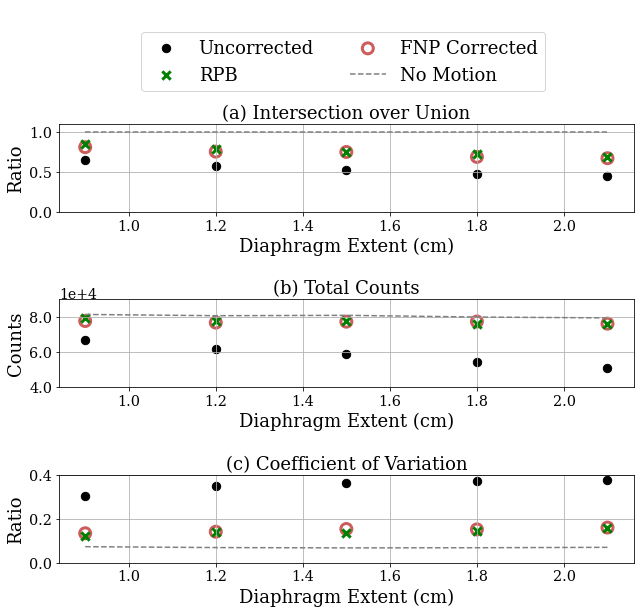

In [3]:
plot_metric_comparison_vert(1.5*np.array(AP_expansions), tot_counts_gt, tot_counts_rb, 
                       tot_counts_orig, tot_counts_corr, 
                       snr_gt, snr_rb, snr_orig, snr_corr, 
                       iou_rb, iou_orig, iou_corr,
                       y_lims=[(0,1.1),(4e4,9e4), (0,0.4)], fontsize=18, 
                       cov=True,
                       x_label='Diaphragm Extent (cm)', 
                   savename='figures/fig8.png')